# Model Training: Defencemen - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Defence position.

## Import our data

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

In [3]:
defence = data[data['POSITION'].isin(['d, l', 'd'])].copy()

# # drop all columns from data that end in '/60'
# defence = defence.drop(data.filter(regex='/60').columns, axis=1)

# Select only players with 41 or more games played
defence_41GP = defence[(defence['GP'] >= 41)].copy()
test_train_data = defence_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0004461655550615426


In [4]:
# # Perform Grid Search to find the optimal parameters
# param_grid = {
#     'regressor__n_estimators': [500, 1000, 1500],
#     'regressor__max_depth': [5, 10, 15],
#     'regressor__reg_lambda': [.1, 1, 10],
#     'regressor__eta': [0.01, 0.1, 0.3]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.score(X_test, y_test))

# # {'regressor__eta': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 500, 'regressor__reg_lambda': 10}
# # 0.44245590658432327
# # 0.41148105470370877

In [5]:
# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Print the sorted feature importances
# for feature, importance in sorted_importances:
#     print(f"{feature}: {importance}")

# If you have a large number of features and only want to see the top ones, you can slice the list
most_important_features = []
print("Top 10 most important features:")
for feature, importance in sorted_importances[:10]:
    print(f"{feature}: {importance}")
    most_important_features.append(feature)


Top 10 most important features:
SF/GP: 0.09133260697126389
OFF. ZONE FACEOFFS/GP: 0.0352935791015625
TOI/GP: 0.030155900865793228
XGF/GP: 0.018506592139601707
SCA/GP: 0.017418233677744865
XGA/GP: 0.016940124332904816
SHOTS/GP: 0.01692347601056099
MISCONDUCT/GP: 0.013631396926939487
OFF. ZONE STARTS/GP: 0.013403785414993763
PIM/GP: 0.013156026601791382


In [6]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [7]:
# Create a feature column in Centers for the predicted salary
defence['PRED_SALARY_PERCENTAGE'] = pipeline.predict(defence)

# Create a column for the actual predicted salary
defence['PRED_AAV'] = defence['PRED_SALARY_PERCENTAGE'] * defence['SALARY CAP']
defence['PRED_AAV'] = defence['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
defence['DIFF'] = defence['PRED_AAV'] - defence['AAV']

# Convert to dollars
defence['PRED_AAV'] = convert_to_dollars(defence, 'PRED_AAV')
defence['AAV'] = convert_to_dollars(defence, 'AAV')
defence['DIFF'] = convert_to_dollars(defence, 'DIFF')

In [8]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = defence.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON']  + most_important_features + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,SF/GP,OFF. ZONE FACEOFFS/GP,TOI/GP,XGF/GP,SCA/GP,XGA/GP,SHOTS/GP,MISCONDUCT/GP,OFF. ZONE STARTS/GP,PIM/GP,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
12897,zdeno chara,2007-08,13.6883,8.9221,26.839610,1.1299,9.6883,1.0779,2.6883,0.0130,3.4935,1.4805,"$7,500,000.00","$6,891,655.00","$-608,345.00",0.137011
4303,erik karlsson,2022-23,15.5854,13.4146,25.615041,1.7195,12.0000,1.3659,2.5488,0.0122,4.8171,0.4390,"$11,500,000.00","$10,935,430.00","$-564,570.00",0.132551
4302,erik karlsson,2021-22,13.9200,9.3400,23.470333,1.2800,11.4800,1.3400,2.3400,0.0000,4.4000,0.2800,"$11,500,000.00","$10,711,572.00","$-788,428.00",0.131430
4304,erik karlsson,2023-24,15.8382,11.4265,24.192892,1.7941,10.0735,1.1029,2.5000,0.0000,4.5588,0.4706,"$11,500,000.00","$10,482,673.00","$-1,017,327.00",0.125541
9669,p.k. subban,2014-15,13.7073,10.9146,26.203252,1.2683,10.7561,1.0976,2.0732,0.0000,4.3171,0.9024,"$9,000,000.00","$8,595,698.00","$-404,302.00",0.124575
11273,shea weber,2012-13,12.5625,9.3125,25.921528,1.1458,9.0833,0.9792,2.5833,0.0417,4.3333,1.0000,"$7,857,143.00","$7,348,670.00","$-508,473.00",0.122478
12898,zdeno chara,2008-09,14.0750,9.0750,26.062083,1.2875,10.6625,1.1375,2.7000,0.0125,3.7625,1.1125,"$7,500,000.00","$6,877,626.00","$-622,374.00",0.121299
4300,erik karlsson,2019-20,13.5714,8.8214,24.522917,1.3393,11.3393,1.2857,2.1607,0.0000,3.6250,0.2857,"$11,500,000.00","$9,873,891.00","$-1,626,109.00",0.121152
3888,drew doughty,2023-24,13.6377,9.4928,25.747826,1.4783,10.9130,1.2319,1.7101,0.0000,3.6232,0.5797,"$11,000,000.00","$10,073,909.00","$-926,091.00",0.120646
9670,p.k. subban,2015-16,15.1176,10.8529,26.362255,1.4265,10.3529,1.1618,2.5882,0.0147,4.8382,1.1029,"$9,000,000.00","$8,593,927.00","$-406,073.00",0.120363


In [9]:
# Display all seasons for Connor McDavid
cale_makar = defence[defence['PLAYER'] == 'cale makar']
cale_makar[display_features]

,PLAYER,SEASON,SF/GP,OFF. ZONE FACEOFFS/GP,TOI/GP,XGF/GP,SCA/GP,XGA/GP,SHOTS/GP,MISCONDUCT/GP,OFF. ZONE STARTS/GP,PIM/GP,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
2113,cale makar,2019-20,13.5263,11.7544,21.010526,1.1579,7.3333,0.7544,2.1228,0.0,5.4035,0.2105,"$2,854,166.00","$2,133,076.00","$-721,090.00",0.026173
2114,cale makar,2020-21,16.2045,12.9091,24.292803,1.6136,7.1136,0.7500,2.3636,0.0,5.7045,0.2727,"$2,854,166.00","$1,845,063.00","$-1,009,103.00",0.022639
2115,cale makar,2021-22,17.5195,13.1039,25.667965,1.7792,9.9740,1.1299,3.1169,0.0,5.7273,0.3377,"$9,000,000.00","$8,398,957.00","$-601,043.00",0.103055
2116,cale makar,2022-23,16.3000,13.6833,26.380278,1.6500,10.7833,1.2833,2.9333,0.0,5.8000,0.5000,"$9,000,000.00","$8,613,100.00","$-386,900.00",0.104401
2117,cale makar,2023-24,15.0938,13.3438,24.926823,1.6406,11.0781,1.3438,3.0312,0.0,6.4219,0.2188,"$9,000,000.00","$7,334,980.00","$-1,665,020.00",0.087844


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Defence')

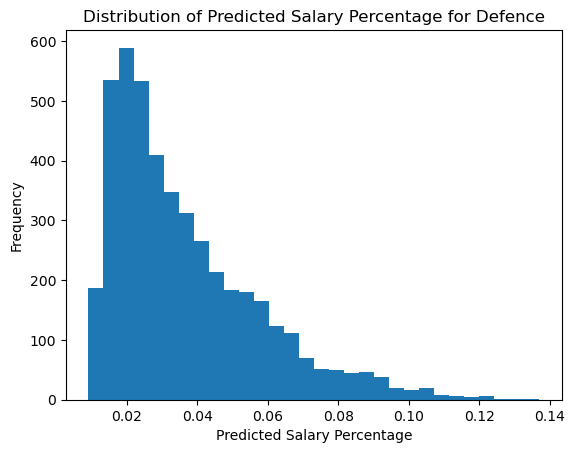

In [10]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(defence['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Defence')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Defence')

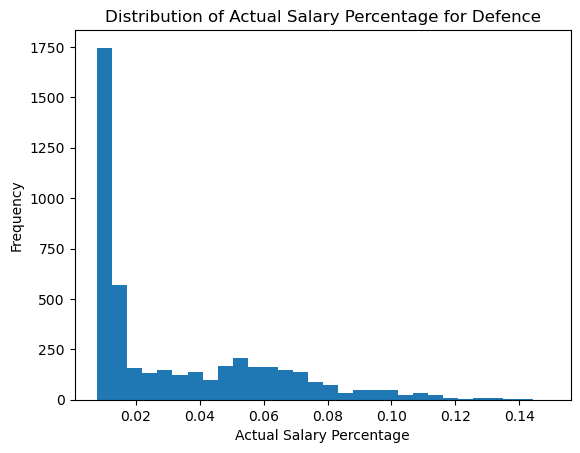

In [11]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(defence['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Defence')

In [12]:
# Filter players with over 41 GP
filtered_data = defence[(defence['GP'] > 60) & (defence['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,SF/GP,OFF. ZONE FACEOFFS/GP,TOI/GP,XGF/GP,SCA/GP,XGA/GP,SHOTS/GP,MISCONDUCT/GP,OFF. ZONE STARTS/GP,PIM/GP,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
5129,ott,jake sanderson,2023-24,12.5846,8.0000,23.043333,1.2462,10.6154,1.1077,2.1231,0.0000,3.6308,0.2923,"$1,850,000.00","$5,454,528.00","$3,604,528.00",0.065324,3604528.0
6721,mtl,kaiden guhle,2023-24,8.5077,4.6769,21.034615,0.8154,11.8769,1.1538,1.3538,0.0000,1.7846,0.8615,"$1,283,333.00","$3,881,768.00","$2,598,435.00",0.046488,2598435.0
1960,min,brock faber,2023-24,12.1571,8.7429,25.089762,1.2714,12.3429,1.3286,1.5714,0.0000,3.8571,0.3429,"$1,008,333.00","$3,299,560.00","$2,291,227.00",0.039516,2291227.0
4863,ari,j.j. moser,2023-24,8.5672,5.5224,20.750995,0.8657,11.4627,1.2836,1.0149,0.0000,2.4776,0.3433,"$925,000.00","$3,057,493.00","$2,132,493.00",0.036617,2132493.0
402,chi,alex vlasic,2023-24,8.8906,6.5469,21.452083,0.8594,11.1250,1.1250,0.9375,0.0156,2.7656,0.6094,"$1,491,667.00","$3,490,751.00","$1,999,084.00",0.041805,1999084.0
11099,ari,sean durzi,2023-24,11.7143,8.8095,22.511111,1.3175,9.9048,1.0794,1.7778,0.0159,3.9365,0.9365,"$1,700,000.00","$3,162,938.00","$1,462,938.00",0.037880,1462938.0
4685,fla,gustav forsling,2023-24,11.2206,6.1765,21.944608,1.1618,10.0588,1.1471,2.0441,0.0147,2.5000,0.6029,"$2,666,667.00","$4,129,003.00","$1,462,336.00",0.049449,1462336.0
2184,phi,cam york,2023-24,11.1143,7.6714,22.152381,1.0714,10.5429,1.0857,1.5000,0.0000,3.3000,0.5429,"$1,600,000.00","$3,045,239.00","$1,445,239.00",0.036470,1445239.0
5140,det,jake walman,2023-24,8.8525,5.0000,19.950820,0.8197,12.7541,1.3279,1.7377,0.0164,2.0656,0.7213,"$3,400,000.00","$4,614,732.00","$1,214,732.00",0.055266,1214732.0
9274,phi,nick seeler,2023-24,9.4444,4.7937,16.968519,0.7778,9.3492,0.8413,1.2857,0.0476,1.7143,1.2381,"$775,000.00","$1,956,168.00","$1,181,168.00",0.023427,1181168.0


In [13]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,SF/GP,OFF. ZONE FACEOFFS/GP,TOI/GP,XGF/GP,SCA/GP,XGA/GP,SHOTS/GP,MISCONDUCT/GP,OFF. ZONE STARTS/GP,PIM/GP,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
7525,cgy,mackenzie weegar,2023-24,12.0441,8.0882,22.468627,1.2353,11.4706,1.2059,2.5294,0.0000,3.0588,0.6618,"$6,250,000.00","$5,577,374.00","$-672,626.00",0.066795,-672626.0
4721,bos,hampus lindholm,2023-24,11.5484,5.8548,23.473387,1.1774,11.1613,1.2258,1.3226,0.0161,2.3548,0.8387,"$6,500,000.00","$5,758,773.00","$-741,227.00",0.068967,-741227.0
9218,wsh,nick jensen,2023-24,7.1818,3.5909,19.585859,0.7273,10.7576,1.2424,0.9394,0.0000,0.9848,0.1212,"$4,050,000.00","$3,180,068.00","$-869,932.00",0.038085,-869932.0
1744,car,brent burns,2023-24,12.6286,9.0571,21.743095,1.3714,8.3571,1.0571,2.2429,0.0000,3.9000,0.2000,"$8,000,000.00","$7,129,365.00","$-870,635.00",0.085382,-870635.0
2174,ana,cam fowler,2023-24,10.8696,8.6957,24.535749,1.0580,13.5072,1.6087,1.4058,0.0000,3.6377,0.2319,"$6,500,000.00","$5,579,206.00","$-920,794.00",0.066817,-920794.0
3888,l.a,drew doughty,2023-24,13.6377,9.4928,25.747826,1.4783,10.9130,1.2319,1.7101,0.0000,3.6232,0.5797,"$11,000,000.00","$10,073,909.00","$-926,091.00",0.120646,-926091.0
5110,tor,jake mccabe,2023-24,9.3770,5.0492,20.578142,0.9836,10.2623,1.0656,1.0000,0.0000,2.0492,0.7541,"$4,000,000.00","$3,067,823.00","$-932,177.00",0.036740,-932177.0
10606,pit,ryan graves,2023-24,9.1029,4.1176,18.450980,0.8676,10.1912,1.0000,1.1176,0.0000,1.5000,0.4412,"$4,500,000.00","$3,567,041.00","$-932,959.00",0.042719,-932959.0
6041,wsh,john carlson,2023-24,12.4559,10.2206,25.627451,1.5441,13.3676,1.5147,1.9853,0.0147,3.5588,0.5882,"$8,000,000.00","$7,049,588.00","$-950,412.00",0.084426,-950412.0
1115,det,ben chiarot,2023-24,8.1077,4.5538,19.498462,0.7385,11.1385,1.0923,1.3692,0.0000,1.9231,0.7692,"$4,750,000.00","$3,771,577.00","$-978,423.00",0.045169,-978423.0


In [14]:
# Show all players who have a positive differential
filtered_data[filtered_data['Differential'] > 0][['TEAM'] + display_features + ['Differential']].head(30)

,TEAM,PLAYER,SEASON,SF/GP,OFF. ZONE FACEOFFS/GP,TOI/GP,XGF/GP,SCA/GP,XGA/GP,SHOTS/GP,MISCONDUCT/GP,OFF. ZONE STARTS/GP,PIM/GP,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
5129,ott,jake sanderson,2023-24,12.5846,8.0000,23.043333,1.2462,10.6154,1.1077,2.1231,0.0000,3.6308,0.2923,"$1,850,000.00","$5,454,528.00","$3,604,528.00",0.065324,3604528.0
6721,mtl,kaiden guhle,2023-24,8.5077,4.6769,21.034615,0.8154,11.8769,1.1538,1.3538,0.0000,1.7846,0.8615,"$1,283,333.00","$3,881,768.00","$2,598,435.00",0.046488,2598435.0
1960,min,brock faber,2023-24,12.1571,8.7429,25.089762,1.2714,12.3429,1.3286,1.5714,0.0000,3.8571,0.3429,"$1,008,333.00","$3,299,560.00","$2,291,227.00",0.039516,2291227.0
4863,ari,j.j. moser,2023-24,8.5672,5.5224,20.750995,0.8657,11.4627,1.2836,1.0149,0.0000,2.4776,0.3433,"$925,000.00","$3,057,493.00","$2,132,493.00",0.036617,2132493.0
402,chi,alex vlasic,2023-24,8.8906,6.5469,21.452083,0.8594,11.1250,1.1250,0.9375,0.0156,2.7656,0.6094,"$1,491,667.00","$3,490,751.00","$1,999,084.00",0.041805,1999084.0
11099,ari,sean durzi,2023-24,11.7143,8.8095,22.511111,1.3175,9.9048,1.0794,1.7778,0.0159,3.9365,0.9365,"$1,700,000.00","$3,162,938.00","$1,462,938.00",0.037880,1462938.0
4685,fla,gustav forsling,2023-24,11.2206,6.1765,21.944608,1.1618,10.0588,1.1471,2.0441,0.0147,2.5000,0.6029,"$2,666,667.00","$4,129,003.00","$1,462,336.00",0.049449,1462336.0
2184,phi,cam york,2023-24,11.1143,7.6714,22.152381,1.0714,10.5429,1.0857,1.5000,0.0000,3.3000,0.5429,"$1,600,000.00","$3,045,239.00","$1,445,239.00",0.036470,1445239.0
5140,det,jake walman,2023-24,8.8525,5.0000,19.950820,0.8197,12.7541,1.3279,1.7377,0.0164,2.0656,0.7213,"$3,400,000.00","$4,614,732.00","$1,214,732.00",0.055266,1214732.0
9274,phi,nick seeler,2023-24,9.4444,4.7937,16.968519,0.7778,9.3492,0.8413,1.2857,0.0476,1.7143,1.2381,"$775,000.00","$1,956,168.00","$1,181,168.00",0.023427,1181168.0


In [15]:
filtered_data[filtered_data['PLAYER'] == 'quinn hughes'][['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,SF/GP,OFF. ZONE FACEOFFS/GP,TOI/GP,XGF/GP,SCA/GP,XGA/GP,SHOTS/GP,MISCONDUCT/GP,OFF. ZONE STARTS/GP,PIM/GP,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
10124,van,quinn hughes,2023-24,14.0429,10.4571,24.723333,1.6857,9.1571,1.0286,2.3857,0.0,4.5714,0.4286,"$7,850,000.00","$7,758,074.00","$-91,926.00",0.092911,-91926.0


In [17]:
predictions = pd.DataFrame(defence['PRED_SALARY_PERCENTAGE'])

# Save predictions to disk
save_dir = '../../Data/predictions/'
filename = 'defence_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=True)